<a href="https://colab.research.google.com/github/isaranwrap/ICM2019/blob/master/hf_coeffs%5Bcreate_preexp_distplot%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import seaborn as sns

import matplotlib.patches as mpatches

from scipy.stats import gaussian_kde

In [0]:
d = pd.read_csv('heart failure death data.csv')
features = ['norepinephrine',
        'map',
        'icu',
        'bnp',
        'flagbands',
        'flagpharterial',
        'potassium',
        'piptazo',
        'buncreatratio',
        'pulse']

#features = ['acearbrenin',
            #'flaganc',
            #'rbcc',
            #'age',
            #'buncreatratio',
            #'bnp',
            #'lymphpercent',
            #'flagurine',
            #'flagpo2',
            #'bun']

outcome = ['inpatient_death'] 
cols = features + outcome

d['map'] = d['diastolic'] + (1/3)*(d['systolic'] - d['diastolic'])

In [0]:
data = d.loc[:,cols]
data.dropna(inplace = True)
data.head()
data.isnull().sum()

norepinephrine     0
map                0
icu                0
bnp                0
flagbands          0
flagpharterial     0
potassium          0
piptazo            0
buncreatratio      0
pulse              0
inpatient_death    0
dtype: int64

In [0]:
y = data.inpatient_death
X = data.drop('inpatient_death', axis=1)

transformer = RobustScaler().fit(X)
center, scale = transformer.center_, transformer.scale_
X_transformed = transformer.transform(X)
#Normalize
#Xmean = X.mean()
#Xstd  = X.std()
#X = (X - Xmean)/Xstd
# dataframe version pd.DataFrame(X_transformed, columns = cols[:-1])

In [0]:
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_transformed, y)

coeffs = np.copy(logreg.coef_[0])
intercept = np.copy(logreg.intercept_)
intercept -= ((center*coeffs)/scale).sum()
coeffs /= scale

logreg_standardized = LogisticRegression(solver = 'lbfgs')
logreg_standardized.fit(X_transformed, y)
logreg_standardized.coef_ = coeffs[None, :]
logreg_standardized.intercept_ = intercept

In [0]:
preds = logreg.predict_proba(X_transformed)[:,1]
auc1 = roc_auc_score(y, preds)
preds_standardized = logreg_standardized.predict_proba(X)[:,1]
auc2 = roc_auc_score(y, preds_standardized)
print(auc1, auc2)

0.8313097301829547 0.8313097301829547


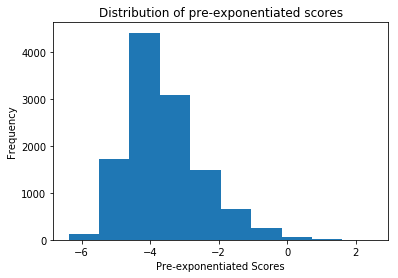

In [0]:
preexp = -np.log(1/preds-1)
plt.hist(preexp)
#sns.distplot(preexp)
plt.title('Distribution of pre-exponentiated scores')
plt.xlabel('Pre-exponentiated Scores')
plt.ylabel('Frequency')
plt.savefig('Distribution of pre-exponentiated scores 2.png')

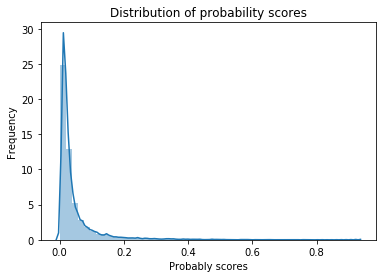

In [0]:
#plt.hist(preds)
sns.distplot(preds)#, norm_hist=False)
plt.title('Distribution of probability scores')
plt.xlabel('Probably scores')
plt.ylabel('Frequency')
plt.savefig('Distribution of probability scores 2.png')

In [0]:
np.percentile(preds, np.arange(0, 100, 10)) #splits into deciles/quartiles

array([0.00169291, 0.00828734, 0.0112772 , 0.01434764, 0.01777262,
       0.02223139, 0.0285639 , 0.03892372, 0.05928552, 0.1104548 ])

In [0]:
preds.sort()
np.any(preds == 0.02223139)

False

In [0]:
preds

array([0.00169291, 0.00183125, 0.00197418, ..., 0.81981675, 0.87098989,
       0.92461896])

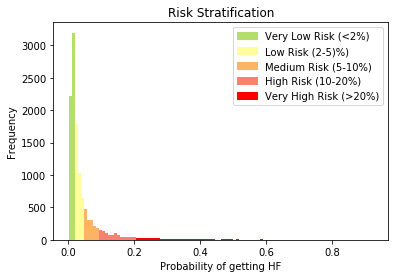

In [0]:
arr = preds
N, bins, patches = plt.hist(arr, bins=100)
cmap = plt.get_cmap('Set3')
vlow = cmap(6)
low = '#FFFF99'
medium =cmap(5)
high = cmap(3)
veryhigh = 'red'

n = 10
stopper = int(N.shape[0])
for i in range(0,int(stopper*0.02)):
    patches[i].set_facecolor(vlow)
for i in range(int(stopper*0.02),int(stopper*0.05)):
    patches[i].set_facecolor(low)
for i in range(int(stopper*0.05),int(stopper*0.1)):
    patches[i].set_facecolor(medium)
for i in range(int(stopper*0.1),int(stopper*0.2)+2):
    patches[i].set_facecolor(high)
for i in range(int(stopper*0.2)+2,int(stopper)):
    patches[i].set_facecolor('red')
    
    
#for item in patches:
 #   item.set_height(item.get_height()/sum(preexp))

#plt.xticks(fontsize=14)  
#plt.yticks(fontsize=14)

vlow_risk = mpatches.Patch(color=vlow, label='Very Low Risk (<2%)')
low_risk = mpatches.Patch(color=low, label='Low Risk (2-5)%)')
medium_risk = mpatches.Patch(color=medium, label='Medium Risk (5-10%)')
high_risk = mpatches.Patch(color=high, label='High Risk (10-20%)')
vhigh_risk = mpatches.Patch(color=veryhigh, label='Very High Risk (>20%)')

risk_levels = [vlow_risk, low_risk, medium_risk, high_risk, vhigh_risk]
plt.legend(handles=risk_levels)
#plt.xlim(0.4, 1)

density = gaussian_kde(arr)
xs = np.linspace(-0,1,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
#plt.plot(xs,density(xs)*200, '+',ms=2,color='purple')
#plt.ylim(0,10)
density(xs).shape
plt.title('Risk Stratification')
plt.ylabel('Frequency')
plt.xlabel('Probability of getting HF')
plt.savefig('Risk Stratification.png')

In [0]:
data.shape

(11802, 11)

236.04

In [0]:
first_tertile = preds[:int(preds.shape[0]/3)]
second_tertile = preds[int(preds.shape[0]/3):int(preds.shape[0]*2/3)]
third_tertile = preds[int(preds.shape[0]*2/3):]

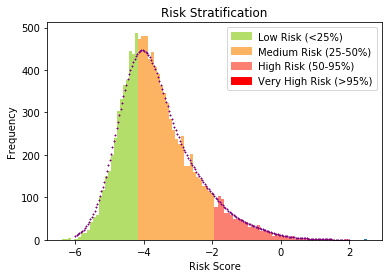

In [0]:
arr = preexp
N, bins, patches = plt.hist(arr, bins=100)
cmap = plt.get_cmap('Set3')
low = cmap(6)
medium =cmap(5)
high = cmap(3)
veryhigh = cmap(2)

n = 4
stopper = int(N.shape[0]/n)
for i in range(0,stopper):
    patches[i].set_facecolor(low)
for i in range(stopper,stopper*2):
    patches[i].set_facecolor(medium)
for i in range(2*stopper,int(stopper*(4*0.95))):
    patches[i].set_facecolor(high)
for i in range(int(stopper*(4*0.95))-1,stopper):
    patches[i].set_facecolor('red')
    
#for item in patches:
 #   item.set_height(item.get_height()/sum(preexp))

#plt.xticks(fontsize=14)  
#plt.yticks(fontsize=14)

low_risk = mpatches.Patch(color=cmap(6), label='Low Risk (<25%)')
medium_risk = mpatches.Patch(color=cmap(5), label='Medium Risk (25-50%)')
high_risk = mpatches.Patch(color=cmap(3), label='High Risk (50-95%)')
vhigh_risk = mpatches.Patch(color='red', label='Very High Risk (>95%)')

risk_levels = [low_risk, medium_risk, high_risk, vhigh_risk]
plt.legend(handles=risk_levels)
#plt.xlim(0.4, 1)

density = gaussian_kde(arr)
xs = np.linspace(-6,2,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs)*1050, '+',ms=2,color='purple')
#plt.ylim(0,10)
density(xs).shape
plt.title('Risk Stratification')
plt.ylabel('Frequency')
plt.xlabel('Risk Score')
plt.savefig('Risk Stratification.png')

In [0]:
bins[stopper], bins[stopper*2], bins[int(stopper*(4*0.95))]

(-4.158003930345928, -1.936393975698154, 2.0625039426678384)

In [0]:
# #of encounters where the risk is greater than pct % 
pct = 0.15
1*(preds > pct).sum()

784

In [0]:
preds.shape

sortedpreds = np.sort(preds)

In [0]:
sortedpreds.shape

(11802,)

In [0]:
print(preds[preds > 0.2].shape)
print(preds[np.logical_and(preds > 0.1, preds < 0.2)].shape)
print(preds[np.logical_and(preds > 0.05, preds < 0.1)].shape)
print(preds[np.logical_and(preds > 0.02, preds < 0.05)].shape)
print(preds[preds < 0.02].shape)

(529,)
(814,)
(1471,)
(3610,)
(5378,)


In [0]:
529 + 814+1471+3610+5378

11802